<a href="https://colab.research.google.com/github/nataliachmurak/colourisation/blob/main/Landscape_GAN_CIELAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -O http://images.cocodataset.org/zips/unlabeled2017.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.7G  100 18.7G    0     0  13.9M      0  0:22:55  0:22:55 --:--:-- 16.4M


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!curl -O http://images.cocodataset.org/zips/train2014.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.5G  100 12.5G    0     0  16.4M      0  0:13:04  0:13:04 --:--:-- 17.0M


In [ ]:
!unzip train2014

In [ ]:
!unzip unlabeled2017

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import os
#colour schemes
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.color import rgb2gray
from skimage.io import imsave, imread
from skimage import io
from skimage.transform import resize

# The batch size we'll use for training
batch_size = 64
# The batch size we'll use for training

# Size of the image required to train our model
img_size = 128

# These many images will be used from the data archive
dataset_split = 4200

master_dir = 'drive/MyDrive/kaggle_dataset'
#master_dir = 'train2014'
#master_dir = 'drive/MyDrive/NCD'
#master_dir = 'mirflirck'
#master_dir='data'
#master_dir = 'unlabeled2017'


#path = "unlabeled2017/000000547486.jpg"
#path2 = "unlabeled2017/000000457142.jpg"
#path2 = "unlabeled2017/000000411995.jpg"
#path2 = "unlabeled2017/000000572384.jpg"
#path2 = "unlabeled2017/000000032121.jpg"
#path = "drive/MyDrive/kaggle_dataset/00000051_(3).jpg"
#path = "drive/MyDrive/NCD/Thumbs.db"
#os.remove(path)
#os.remove(path)
#os.remove(path2)
import os

x = []
y = []
groundTruth = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    rgb_img_array = (np.asarray( rgb_image ) ) 
    image = rgb_img_array
    Y = rgb2lab(1.0/255 * image)[:,:,1:]
    Y = Y / 128
    X = rgb2lab(1.0/255 * image)[:,:,0]
    X = np.expand_dims(X, 2)
    x.append(X)
    y.append(Y)
    groundTruth.append(image)

print(X.shape)
print(Y.shape)   
print(image.shape)

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x), np.array(y), test_size=0.1 )
print(train_x.shape)
print(train_y.shape)
print(test_y.shape)
groundTruth_train, groundTruth_test = train_test_split(np.array(groundTruth), test_size=0.1)
print(groundTruth_train.shape)
print(groundTruth_test.shape)
# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )




(128, 128, 1)
(128, 128, 2)
(128, 128, 3)
(3761, 128, 128, 1)
(3761, 128, 128, 2)
(418, 128, 128, 2)
(3761, 128, 128, 3)
(418, 128, 128, 3)


In [8]:
def get_gen():
  layers = [
    tf.keras.layers.Input( shape=( 128 , 128 , 1 ) ),

    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 ),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 ),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1 ),
    tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ), strides=1 ),
    tf.keras.layers.LeakyReLU(),
    

    tf.keras.layers.Conv2DTranspose( 256 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.Conv2DTranspose( 256 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),

    
    #tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2DTranspose( 16 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2DTranspose( 8 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),

    
    #tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    #tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    tf.keras.layers.Conv2DTranspose( 2 , kernel_size=( 5 , 5 ) , strides=1 , activation='tanh') ]
  model = tf.keras.models.Sequential( layers ) 
    
  print(model.summary())
  return model

In [23]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( 128 , 128 , 1 ) )

    #conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    #conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    #conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    #conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    #conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    #conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    #conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    #conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    #conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    #conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    #conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    #conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    #conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    #conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    #conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    #conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    #conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    #conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    #bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' , padding='same' )( conv3 )

    #concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    #conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    #conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    #conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    #concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    #conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    #conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    #conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    #concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    #conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    #conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    #conv_up_1 = tf.keras.layers.Conv2DTranspose( 2 , kernel_size=( 5 , 5 ) , strides=1 , activation='tanh')( conv_up_1 )
    layers = [
      tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same', strides=2),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2D(2, (3, 3), activation='tanh', padding='same') ]
    model = tf.keras.models.Sequential( layers ) 
    #model = tf.keras.models.Model( inputs , conv_up_1 )
    print(model.summary())
    return model

In [9]:

def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 128 , 128 , 2 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    print(model.summary())
    return model

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_gen()
discriminator = get_discriminator_model()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 120, 120, 64)      51264     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 116, 116, 64)      102464    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 116, 116, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 114, 114, 128)    

In [11]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        #print(gen_loss)
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
num_epochs = 60

for e in range( num_epochs ):
    print( e )
    for ( x, y ) in dataset:
      # Here ( x , y ) represents a batch from our training dataset.
      print( x.shape )
      train_step( x , y )


0
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128, 128, 1)
(64, 128

In [ ]:
import matplotlib.pyplot as plt

y = generator( test_x[ 0 : 418 ] ).numpy()
y = y * 128
#print(y.shape)
#print(test_x.shape)

#import
#import dumpy as npmse = (np.square(X - Y)).mean(axis=None)
#mse = (np.square(X - Y)).mean(axis=None)
#X, Y - groundtruth/ output
#test_gen = generator_loss(y, test_y[:418])
#tf.keras.backend.print_tensor( tf.keras.backend.mean( test_gen ) )


#looping through test data for the metrics
#final_array = np.zeros((418, 128, 128, 3))
for i in range(418):
  name = str(i)
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = test_x[i][:,:,0]
  cur[:,:,1:] = y[i]
  final = lab2rgb(cur)
  #final_array[0,:,:,:] = final
  imsave(name + "_color.jpg", final)
  
#print(final_array.shape)

#final2 = np.zeros((10000, 32, 32, 3))

#for i in range(10000):
#  cur = np.zeros((32, 32, 3))
#  cur[:,:,0] = testX[i][:,:,0]
#  cur[:,:,1:] = output[i]
#  final = lab2rgb(cur)
#  final2[0,:,:,:] = final

#print(final2.shape)


In [ ]:
test_y = test_y * 128
original_array = np.zeros((418, 128, 128, 3))
for i in range(418):
  cur2 = np.zeros((128, 128, 3))
  cur2[:,:,0] = test_x[i][:,:,0]
  cur2[:,:,1:] = test_y[i]
  original = lab2rgb(cur2)
  original_array[0,:,:,:] = original

print(original.shape)
print(original_array.shape)  


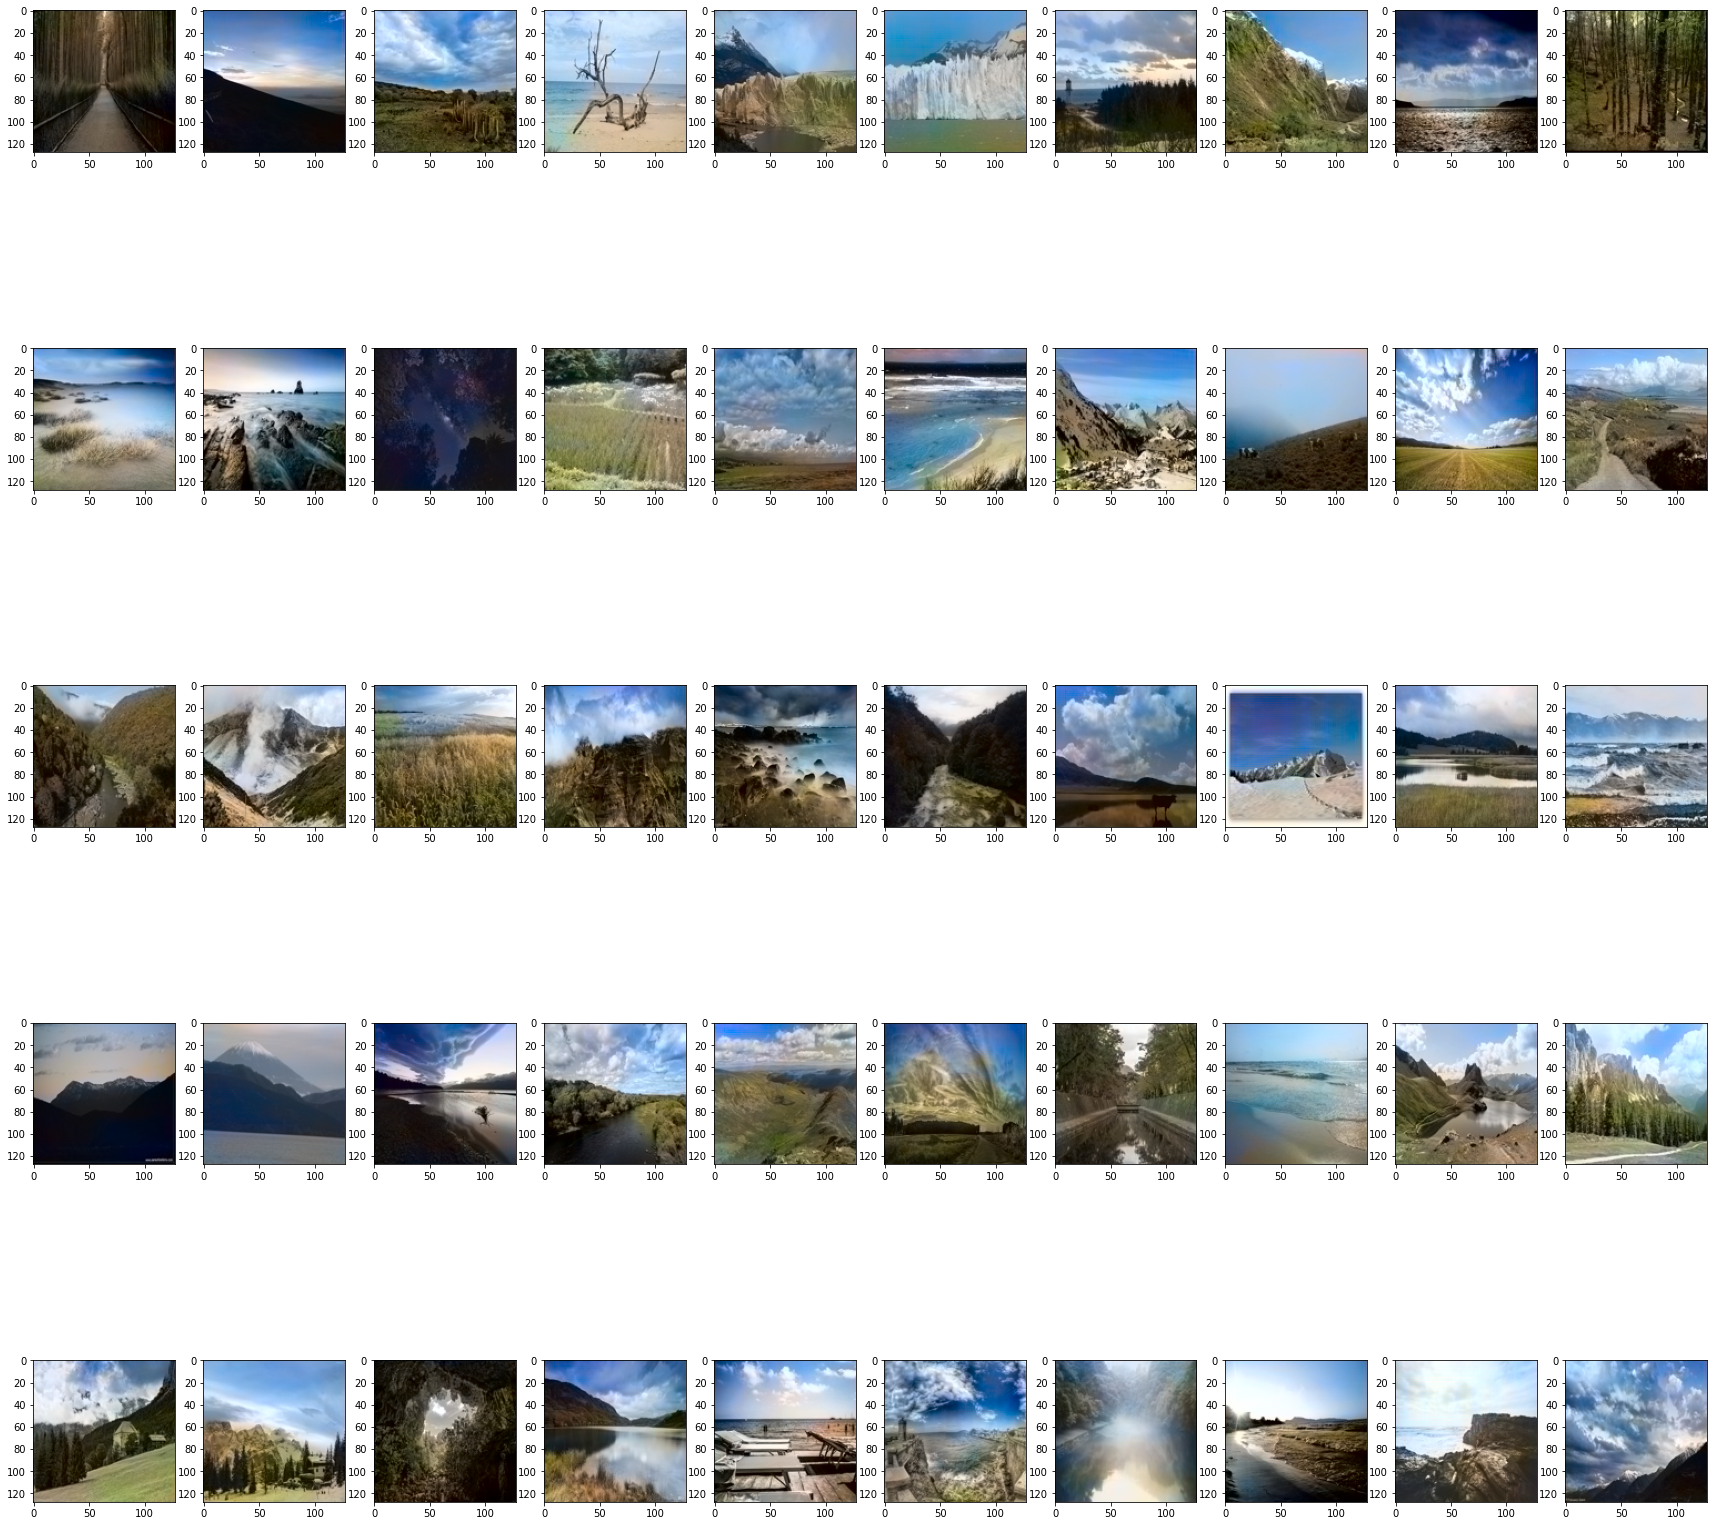

In [28]:
#displaying
import matplotlib.pyplot as plt

y = generator( test_x[ 0 : 50 ] ).numpy()
y = y * 128
plt.figure(figsize=(30, 30))
for i in range(50):
  #name = str(i)
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = test_x[i][:,:,0]
  cur[:,:,1:] = y[i]
  #final = final.resize((256, 256))
  final = lab2rgb(cur)
  plt.subplot(5, 10, i+1)
  plt.imshow( final )
  #imsave(name + "_color.jpg", final)
plt.show()


In [ ]:
test_y = test_y * 128
#plt.figure(figsize=(30, 30))
for i in range(418):
  name = str(i)
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = test_x[i][:,:,0]
  cur[:,:,1:] = test_y[i]
  original = lab2rgb(cur)
  #plt.subplot(5, 6, i+1)
  #plt.imshow(original)
  imsave(name + "_original.jpg", original)
#plt.show()  



In [ ]:
for i in range(418):
  name = str(i)
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = test_x[i][:,:,0]
  #cur[:,:,1:] = test_y[i]
  bw = lab2rgb(cur)
  #plt.subplot(5, 6, i+1)
  #plt.imshow(original)
  imsave(name + "_bw.jpg", bw)
#plt.show()  

In [ ]:
#PSNR

print('PSNR metrics - SUM AND MEAN')

psnr_array =[]

for i in range(418):
  psnr = tf.image.psnr(original_array[i], final_array[i], max_val=255)
  psnr_array.append(psnr)

sum = 0 
for j in range(0, len(psnr_array)):
  #print(psnr_array[j])
  sum += psnr_array[j]

mean = sum / 418
print(sum)
print(mean)



PSNR metrics - SUM AND MEAN
tf.Tensor(inf, shape=(), dtype=float32)
tf.Tensor(inf, shape=(), dtype=float32)


In [ ]:
#SSIM
print('SSIM - Sum and mean')
ssim_array = []
for i in range(418):
  im1 = tf.image.convert_image_dtype(original_array[i], tf.float32)
  im2 = tf.image.convert_image_dtype(final_array[i], tf.float32)
  ssim = tf.image.ssim(im1, im1, max_val=1.0)
  ssim_array.append(ssim)

sum = 0 
for i in range(0, len(ssim_array)):
  #print(ssim_array[i])
  sum = sum + ssim_array[i]

mean = sum / len(ssim_array)
print(sum)
print(mean)

SSIM - Sum and mean
tf.Tensor(418.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
#SAD

print('SAD - Sum and mean')
sad_array = []
for i in range(418):
  sad = np.sum(abs(original_array[i] - final_array[i]))
  sad_array.append(sad)

print(len(sad_array))  
sum = 0 
for i in range(0, len(sad_array)):
  #print(sad_array[i])
  sum = sum + sad_array[i]


mean = sum / len(sad_array)
print(sum)
print(mean)

SAD - Sum and mean
418
2653.62622126934
6.348388089161101
